In [48]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)

import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('white')
plt.style.use('dark_background')

rc = plt.rcParams
rc['axes.spines.right'], rc['axes.spines.top'] = 0,0
rc['axes.facecolor'], rc['figure.facecolor'] = (1,1,1,0), (1,1,1,0)
rc['legend.frameon'] = False


Populating the interactive namespace from numpy and matplotlib


/Users/laic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
%gui qt

In [50]:
spk_df = pd.read_pickle('./spk_matrix.pd')
spk_df['spk_time']/=25000.

In [51]:
spk_df

,spk_time,spk_id
0,0.16524,0
1,0.17832,0
2,0.25864,0
3,0.28076,0
4,0.28164,6
...,...,...
9304,371.07876,3
9305,371.10516,3
9306,371.12024,0
9307,371.12540,0


In [52]:
from spiketag.core import CCG

In [53]:
spk_time=spk_df['spk_time'].to_numpy()
spk_id  =spk_df['spk_id'].to_numpy()

In [295]:
ccg = CCG(np.round(spk_time*25000).astype(np.int), spk_id, window_bins=60)

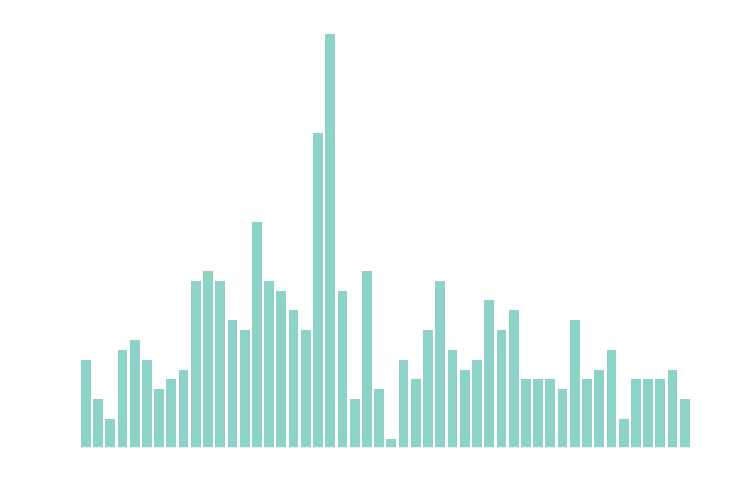

In [304]:
plt.bar(np.arange(-24.5,25.5), ccg[5,4]);
# plt.vlines(x=[0,-20,20], ymin=0, ymax=40, color='w')

In [297]:
mask = np.ones_like(spk_time, dtype=np.bool)

In [303]:
mask[:-1].any()

True

In [305]:
from spiketag.analysis import spike_binning

In [306]:
def window_gen(window_len=50):
    ttbb = np.arange(-window_len//2, window_len//2+1)*1e-3
    return np.vstack((ttbb[:-1],ttbb[1:])).T

In [307]:
win = window_gen(window_len=50)

In [308]:
win.shape

(50, 2)

In [ ]:
c = spike_binning(spike_time=spk_time, event_time=spk_time[spk_id==5], 
                  spike_id=spk_id, 
                  windows=win)

In [261]:
c = spike_binning(spike_time=spk_time[spk_id==4], event_time=spk_time[spk_id==5], 
                  windows=win)

In [67]:
c = spike_binning(spike_time=spk_time, event_time=np.arange(0.16, 371, 5e-3), spike_id=spk_id,
                  windows=[-20e-3, 0])

In [253]:
c.shape

(50, 1283)

In [262]:
ccg[5,4][4]

11

In [263]:
_ccg = np.squeeze(c.sum(axis=1))

In [264]:
_ccg[4]

10.0

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1. -1.  0.  0. -1.  0.  0.  0. -4. -2. -3. -1. -1. -2.  0. -1.
  0. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.]


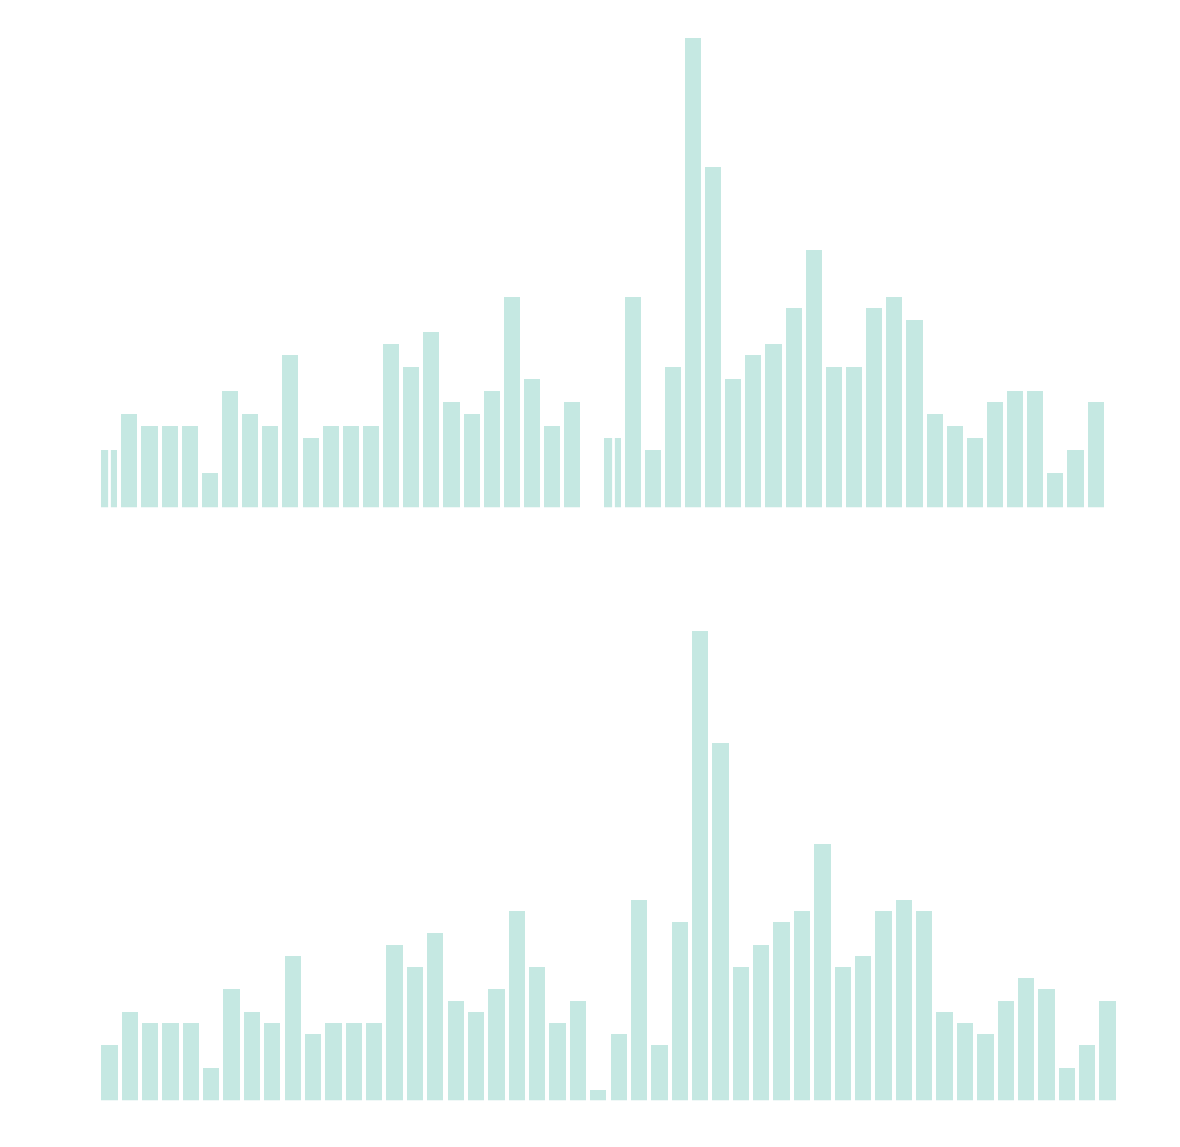

In [322]:
pairs = (5,4)
fig, ax = plt.subplots(2,1, figsize=(10,10))
c = spike_binning(spike_time=spk_time[spk_id==pairs[0]], event_time=spk_time[spk_id==pairs[1]], 
                  windows=win)
_ccg = np.squeeze(c.sum(axis=1))
ax[0].bar(np.arange(-25,25), _ccg, alpha=.5);
ax[0].vlines([-25,25,0], ymin=0, ymax=40, color='w')
ax[1].bar(np.arange(-25,25), ccg[pairs[1], pairs[0]], alpha=.5);
print(_ccg - ccg[pairs[1], pairs[0]])

In [241]:
_ccg - ccg[5,4]

array([ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,
        0., -1.,  0., -2., -1., -1., -3., -2., -4.,  0.,  0.,  0., -1.,
        0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [181]:
%%timeit
_c = count_spike(spk_time[spk_id==4], spk_time[spk_id==5], win[25])

18.5 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [183]:
# %%timeit
c  = spike_binning(spk_time[spk_id==4], spk_time[spk_id==5], windows=win[25])

In [184]:
np.allclose(_c, c)

True

In [165]:
def count_spike(time_spike, time_event, window=[-0.5, 0.5]):
    def count_spk(time_spike, time_event, window):
        if np.isnan(time_event):
            return np.nan        
        in_time = (time_spike >= time_event + window[0]) & (time_spike < time_event + window[1])
        return np.sum(in_time).astype(np.float)

    return np.vectorize(lambda x: count_spk(time_spike, x, window))(time_event)

In [17]:
from numba import njit, prange

In [10]:
@njit(cache=True)
def count_spike_2(time_spike, time_event, window=[-0.5, 0.5]):
    count = np.zeros_like(time_event)
    for i in range(time_event.shape[0]):
        in_time = (time_spike>=time_event[i]+window[0]) & (time_spike<=time_event[i]+window[1])
        count[i] = np.sum(in_time)
    return count

In [11]:
@njit(cache=True)
def count_spike_3(time_spike, time_event, window=[-0.5, 0.5]):
    count = np.zeros_like(time_event)
    idx_start = np.searchsorted(time_spike, time_event+window[0], side='right')
    for i in range(time_event.shape[0]):
        nspk = 0
        while True:
            idx = idx_start[i] + nspk
            if time_spike[idx] >= time_event[i]+window[0] and time_spike[idx] <= time_event[i]+window[1]:
                nspk+=1
            else:
                break
        count[i] = nspk
    return count

In [12]:
@njit(cache=True)
def count_spike_4(time_spike, time_event, window=[-0.5, 0.5]):
    '''
    count the `spike_time` in `window` that around each `time_event`
    '''
    count = np.zeros_like(time_event)
    idx_start = np.searchsorted(time_spike, time_event+window[0], side='right')
    for i in range(time_event.shape[0]):
        nspk = 0
        while True:
            idx = idx_start[i] + nspk
            if time_spike[idx] >= time_event[i]+window[0] and time_spike[idx] < time_event[i]+window[1]:
                nspk+=1
            else:
                break
        count[i] = nspk
    return count

In [13]:
@njit(cache=True, parallel=True, fastmath=True)
def count_spike_5(time_spike, time_event, windows=np.array([[-0.5, 0.5]])):
    '''
    count the `spike_time` in an array of `window` that around each `time_event`
    '''
    nwin = windows.shape[0]
    npts = time_event.shape[0]
    count = np.zeros((nwin, npts))
    for k in prange(nwin):
        window = windows[k]
        idx_start = np.searchsorted(time_spike, time_event+window[0], side='right')
        for i in range(time_event.shape[0]):
            nspk = 0
            while True:
                idx = idx_start[i] + nspk
                if time_spike[idx] >= time_event[i]+window[0] and time_spike[idx] < time_event[i]+window[1]:
                    nspk+=1
                else:
                    break
            count[k, i] = nspk
    return count

In [14]:
@njit(cache=True, parallel=True, fastmath=True)
def spike_binning(spike_time, event_time, spike_id=None, windows=np.array([[-0.5, 0.5]])):
    '''
    bin(count) the `spike_time` in an array of `window` that around `time_event`.
    --------
    Parameters
    ----------
    spike_time: a numpy array contains time stamps of spikes
    event_time: a numpy array (M,) contains time stamps of binning position
    windows:    a numpy array (N,2) contains N binning window 
    
    Returns
    -------
    count: a numpy array representing the binning result (N,M)
    '''
    
    nwin = windows.shape[0]
    npts = event_time.shape[0]
    count = np.zeros((nwin, npts))
    for k in prange(nwin):
        window = windows[k]
        idx_start = np.searchsorted(spike_time, event_time+window[0], side='right')
        for i in range(event_time.shape[0]):
            nspk = 0
            while True:
                idx = idx_start[i] + nspk
                if spike_time[idx] >= event_time[i]+window[0] and spike_time[idx] < event_time[i]+window[1]:
                    nspk+=1
                else:
                    break
            count[k, i] = nspk
    return count

In [18]:
@njit(cache=True, parallel=True, fastmath=True)
def _spike_binning(spike_time, event_time, spike_id, windows=np.array([-0.5, 0.5])):
    '''
    bin(count) the `spike_time` in an array of `window` that around `time_event`.
    related issue: https://github.com/chongxi/spiketag/issues/57
    --------
    Parameters
    ----------
    spike_time: a numpy array (T,) contains time stamps of spikes
    event_time: a numpy array (B,) contains time stamps of binning position
    spike_id:   a numpy array (T,) contains spike ids with (N,) unique labels
    window:    a numpy array (2,) contains the binning window 
    
    Returns
    -------
    B is #events(#bins), N is #cells, W is #window
    count: a numpy array representing the binning result (W, B, N)
    '''
    
    B = event_time.shape[0]
    cell_ids = np.unique(spike_id)
    N = np.unique(cell_ids).shape[0]
    spike_id -= cell_ids.min()
    W = windows.shape[0]
    count = np.zeros((W, B, N))  # (#Win, #Bin, #Cell)
    
    for k in prange(N):
        _spike_time = spike_time[spike_id==k]
#         print(_spike_time.shape)
        for w in range(W):
            window = windows[w]
            idx_start = np.searchsorted(_spike_time, event_time+window[0], side='right')
            for i in range(event_time.shape[0]):
                nspk = 0
                while True:
                    idx = int(idx_start[i] + nspk)
                    if idx<_spike_time.shape[0] and event_time[i]+window[0] <= _spike_time[idx] and _spike_time[idx] < event_time[i]+window[1]:
                        nspk+=1      
                    else:
                        break
                count[w, i, k] = nspk
    return count


def spike_binning(spike_time, event_time, spike_id=None, windows=np.array([[-0.5, 0.5]])):
    if spike_id is None:
        spike_id = np.zeros_like(spike_time)
    return _spike_binning(spike_time, event_time, spike_id, windows)
    
    

In [19]:
win = window_gen()

In [20]:
c = spike_binning(spike_time=spk_time/25000., event_time=spk_time[spk_id==5]/25000., 
                  spike_id=spk_id, 
                  windows=win)

In [22]:
c.shape

(50, 1283, 8)

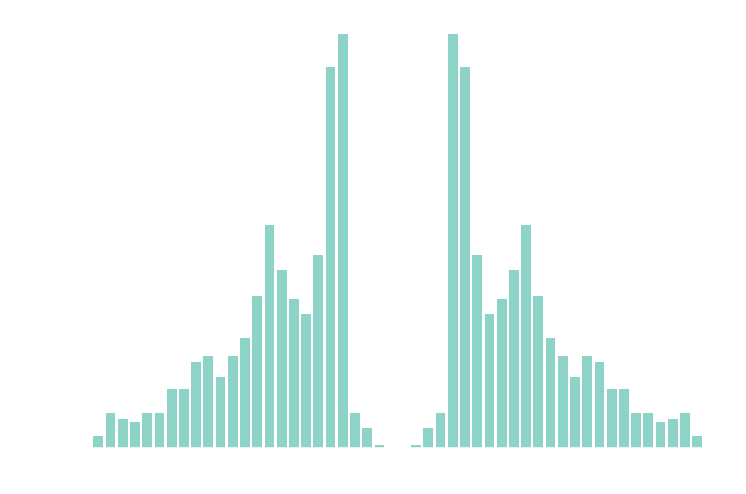

In [222]:
plt.bar(np.arange(-25,25), c.sum(axis=1)[:,5]);

In [149]:
c = spike_binning(spike_time=spk_time[spk_id==4]/25000, event_time=spk_time[spk_id==5]/25000,
                  window=[-0.5, 0.5])

In [173]:
c

array([[ 9.,  1.,  0., ...,  2.,  2.,  0.],
       [ 9.,  1.,  0., ...,  2.,  2.,  0.],
       [ 8.,  1.,  0., ...,  3.,  2.,  0.],
       ...,
       [10.,  0.,  0., ...,  3.,  7.,  0.],
       [10.,  0.,  0., ...,  3.,  7.,  0.],
       [12.,  0.,  0., ...,  3.,  9.,  0.]])

In [ ]:
c = spike_binning(spk_time, spk_time[spk_id==5], 
                  spike_id=np.zeros((988,)).astype(np.int32), 
                  window=[-0.5*25000., 0.5*25000.])

In [101]:
c4 = count_spike_4(spk_time[spk_id==4], spk_time[spk_id==5], 
                   window=[-0.5*25000., 0.5*25000.])

In [102]:
c.shape

(1283, 1)

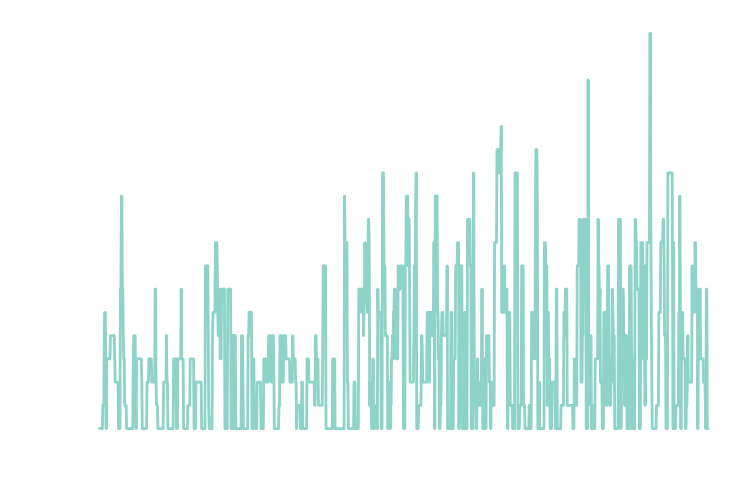

In [103]:
plot(c4.ravel())

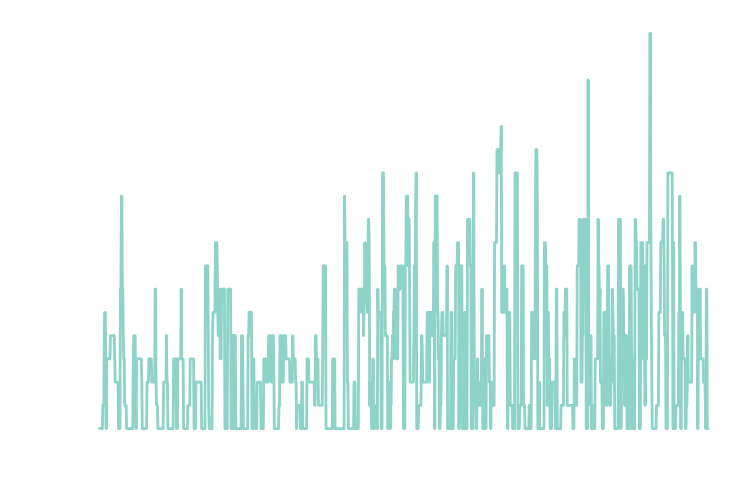

In [104]:
plot(c.ravel())

ValueError: shape mismatch: objects cannot be broadcast to a single shape

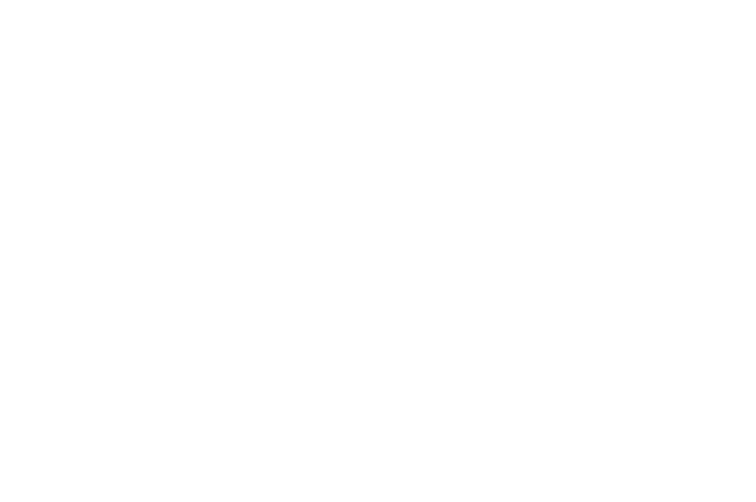

In [105]:
plt.bar(np.arange(-24.5, 25.5), c.sum(axis=1));

In [334]:
%%timeit
c2 = CCG2(spk_time[spk_id==4], spk_time[spk_id==5], window_len=50)

861 µs ± 47.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


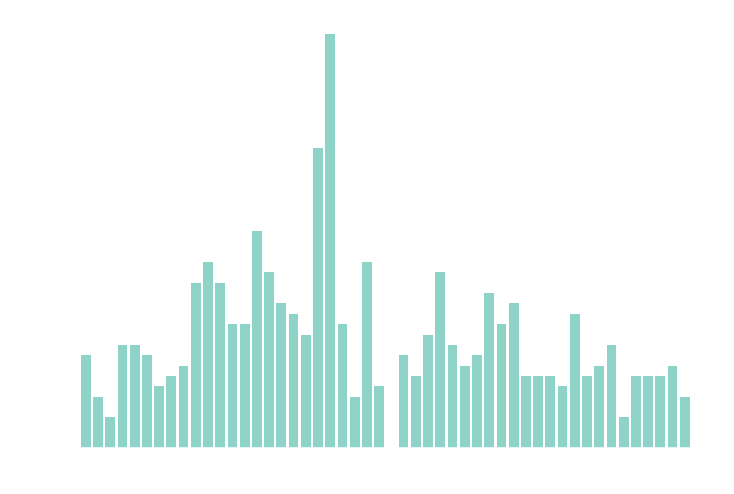

In [330]:
plt.bar(np.arange(-24.5, 25.5), c2);

In [327]:
@njit(cache=True, parallel=True, fastmath=True)
def CCG2(time_spike_1, time_spike_2, window_len=50):
    bins = np.arange(-window_len//2, window_len//2+1)*1e-3
    _win = np.vstack((bins[:-1], bins[1:])).T
    _ccg = np.zeros((window_len,))
    for i in prange(window_len):
        _ccg[i] = np.sum(count_spike_4(time_spike_1, time_spike_2, window=_win[i]*25000))
    return _ccg

In [178]:
%%timeit
c = count_spike(spk_time[spk_id==4], spk_time[spk_id==5], window=[-0.5*25000., 0.5*25000.])

20.6 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
c2 = count_spike_2(spk_time[spk_id==4], spk_time[spk_id==5], window=[-0.5*25000., 0.5*25000.])

1.72 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
%%timeit
c3 = count_spike_3(spk_time[spk_id==4], spk_time[spk_id==5], window=[-0.5*25000., 0.5*25000.])

220 µs ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [65]:
%%timeit
c4 = count_spike_4(spk_time[spk_id==4], spk_time[spk_id==5], window=[-0.5*25000., 0.5*25000.])

193 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
def window_gen(window_len=50):
    ttbb = np.arange(-window_len//2, window_len//2+1)*1e-3
    return np.vstack((ttbb[:-1],ttbb[1:])).T

In [18]:
window_gen()

array([[-0.025, -0.024],
       [-0.024, -0.023],
       [-0.023, -0.022],
       [-0.022, -0.021],
       [-0.021, -0.02 ],
       [-0.02 , -0.019],
       [-0.019, -0.018],
       [-0.018, -0.017],
       [-0.017, -0.016],
       [-0.016, -0.015],
       [-0.015, -0.014],
       [-0.014, -0.013],
       [-0.013, -0.012],
       [-0.012, -0.011],
       [-0.011, -0.01 ],
       [-0.01 , -0.009],
       [-0.009, -0.008],
       [-0.008, -0.007],
       [-0.007, -0.006],
       [-0.006, -0.005],
       [-0.005, -0.004],
       [-0.004, -0.003],
       [-0.003, -0.002],
       [-0.002, -0.001],
       [-0.001,  0.   ],
       [ 0.   ,  0.001],
       [ 0.001,  0.002],
       [ 0.002,  0.003],
       [ 0.003,  0.004],
       [ 0.004,  0.005],
       [ 0.005,  0.006],
       [ 0.006,  0.007],
       [ 0.007,  0.008],
       [ 0.008,  0.009],
       [ 0.009,  0.01 ],
       [ 0.01 ,  0.011],
       [ 0.011,  0.012],
       [ 0.012,  0.013],
       [ 0.013,  0.014],
       [ 0.014,  0.015],


In [180]:
count_spike_4(spk_time[spk_id==4], spk_time[spk_id==5], window=_win[49]*25000)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [240]:
_ccg = CCG2(spk_time[spk_id==0], spk_time[spk_id==5], window_len=50)

<BarContainer object of 50 artists>

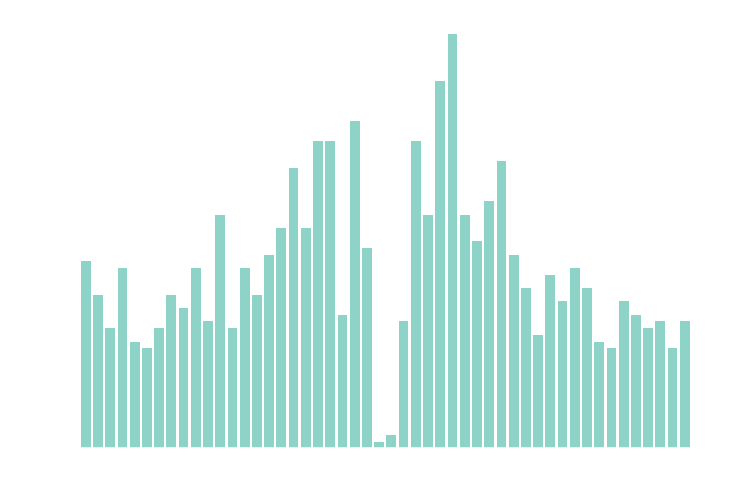

In [241]:
plt.bar(np.arange(-24.5, 25.5), _ccg)

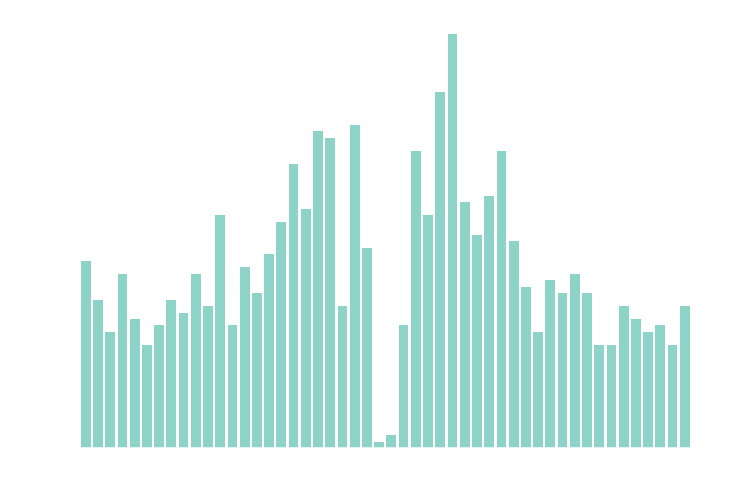

In [242]:
plt.bar(np.arange(-24.5,25.5), ccg[5,0]);

In [235]:
_ccg - ccg[5,2]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

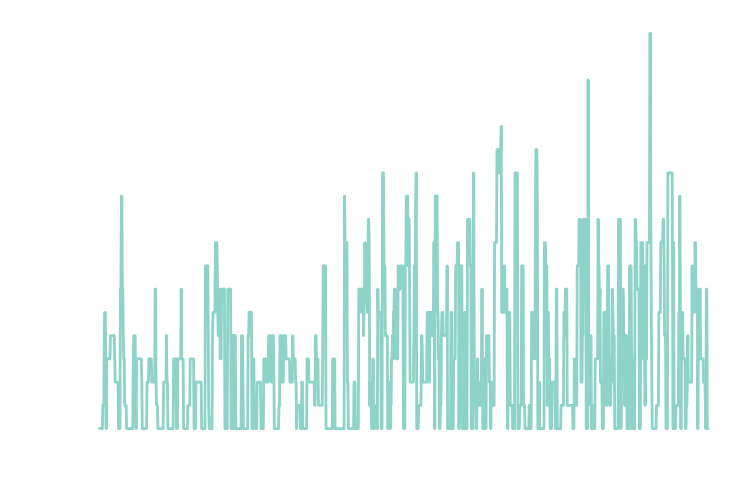

In [60]:
plot(c4)

In [66]:
count_spike_4(spk_time[spk_id==4], spk_time[spk_id==5], window=_win[49]*25000)

NameError: name '_win' is not defined

In [14]:
np.allclose(c, c2)

True

In [36]:
np.allclose(c, c3)

True

In [62]:
np.allclose(c, c4)

True